# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 0
N_JOBS = 6

# Reading final test data

In [3]:
final_test_df = pd.read_csv("data/processed/test_language_detection_dataset.csv")
final_test_df.head()

,sentence,lan_code
0,Tom couldn't believe how ugly Mary became as s...,eng
1,I'm ready to go now.,eng
2,Что у тебя на этой грядке?,rus
3,"""Он говорит, что хочет есть.""",rus
4,Я решил туда пойти.,rus


In [4]:
X_final_test = final_test_df["sentence"]
y_final_test = final_test_df["lan_code"]

# Initializing models

Here we're gonna initialize our own models as well as two pre-trained popular models for language detection - Lingua and fast-langdetect, both of which feature all 3 of our languages, to compare perfomance of our models with already existing ones.

We have excluded XLM-RoBERTa from this comparison due to its model size. Being a large transformer, it is disproportionately larger than the lightweight architectures of the four models we are evaluating, making a direct comparison of efficiency and resource usage impractical.

In [5]:
from utils.models.transformers import TextCleaner

## SGDClassifier-based model

In [6]:
sgd_model_path = "models/dev/sgd_language_detection_model.joblib"

In [7]:
sgd_model = joblib.load(sgd_model_path)
sgd_model

,clf,Pipeline(step...om_state=0))])
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [8]:
def detect_languages_sgd(series: pd.Series) -> pd.Series:
    y_pred = sgd_model.predict(series)
    return y_pred

## MultinomialNB-based model

In [9]:
mnb_model_path = "models/dev/mnb_language_detection_model.joblib"

In [10]:
mnb_model = joblib.load(mnb_model_path)
mnb_model

,clf,Pipeline(step...874113e-05))])
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None
,stop_words,None
,token_pattern,'(?u)\\b\\w\\w+\\b'
,ngram_range,"(1, ...)"


In [11]:
def detect_languages_mnb(series: pd.Series) -> pd.Series:
    y_pred = mnb_model.predict(series)
    return y_pred

## Lingua

In [12]:
from lingua import Language, LanguageDetectorBuilder

In [13]:
languages = [Language.ENGLISH, Language.RUSSIAN, Language.UKRAINIAN]
lingua_detector = LanguageDetectorBuilder.from_languages(*languages).build()

In [14]:
def detect_languages_lingua(series: pd.Series) -> pd.Series:
    codes_map = {
        "en" : "eng",
        "ru" : "rus",
        "uk" : "ukr"
    }

    def get_lang_code(text):
        if not isinstance(text, str) or not text.strip():
            return None
            
        res = lingua_detector.detect_language_of(text)
        
        # Convert Enum to string ISO code (e.g., Language.ENGLISH -> 'EN')
        if res:
            return codes_map[res.iso_code_639_1.name.lower()]
        return "unknown"

    results = series.apply(get_lang_code)

    result_df = pd.DataFrame(results.tolist(), columns=['detected_lang'], index=series.index)
    
    return result_df

## fast-langdetect

In [15]:
from fast_langdetect import detect

In [16]:
def detect_languages_fast_langdetect(series: pd.Series) -> pd.Series:
    clean_series = series.astype(str).str.replace('\n', ' ', regex=False).fillna('')

    codes_map = {
        "en" : "eng",
        "ru" : "rus",
        "uk" : "ukr"
    }

    def safe_detect(text):
        if not text or text.isspace():
            return 'unknown'
        try:
            result = detect(text, model="auto", k=1)
            return codes_map[result[0]['lang']]
        except Exception as e:
            return 'unknown'

    results = clean_series.apply(safe_detect)

    result_df = pd.DataFrame(results.tolist(), columns=['detected_lang'], index=series.index)
    
    return result_df

# Testing

In [17]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, \
                            accuracy_score, recall_score, precision_score

In [18]:
predictors = {
    "sgd": detect_languages_sgd,
    "mnb": detect_languages_mnb,
    "lingua": detect_languages_lingua,
    "fast-langdetect": detect_languages_fast_langdetect
}

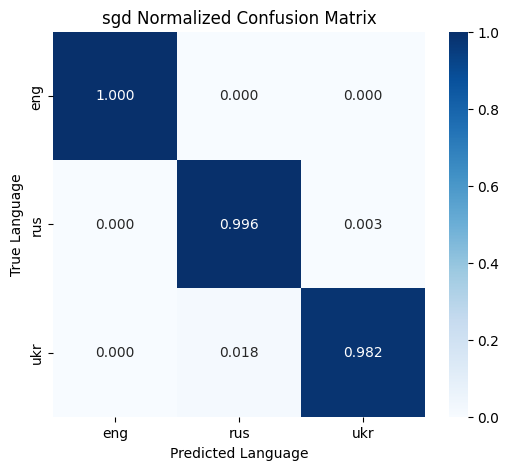

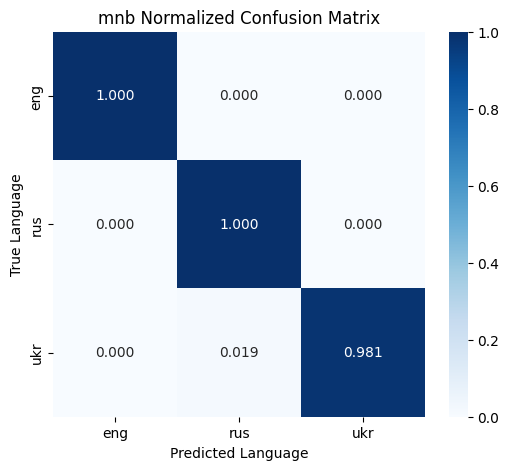

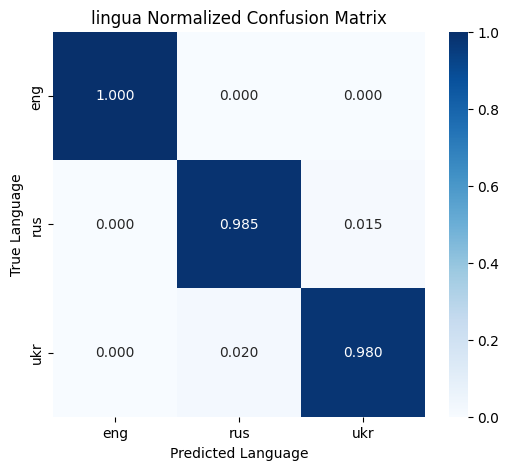

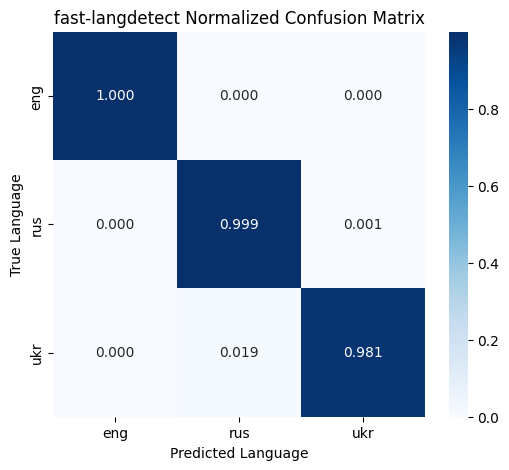

In [19]:
results = []

valid_labels = np.unique(y_final_test)

for name, predictor in predictors.items():
    start_time = time.time()
    
    preds = predictor(X_final_test)
    
    end_time = time.time()
    elapsed = end_time - start_time
    samples_per_sec = len(X_final_test) / elapsed if elapsed > 0 else 0
    
    macro_f1 = f1_score(y_final_test, preds, average='macro', labels=valid_labels, zero_division=0)
    accuracy = accuracy_score(y_final_test, preds)
    
    recalls = recall_score(y_final_test, preds, average=None, labels=valid_labels, zero_division=0)
    precisions = precision_score(y_final_test, preds, average=None, labels=valid_labels, zero_division=0)
    
    row = {
        "Model": name,
        "Macro F1": macro_f1,
        "Accuracy": accuracy,
        "Speed (samples/sec)": int(samples_per_sec)
    }
    
    for i, label in enumerate(valid_labels):
        row[f"{label} Recall"] = recalls[i]
        row[f"{label} Precision"] = precisions[i]
        
    results.append(row)

    cm = confusion_matrix(y_final_test, preds, labels=valid_labels, normalize='true')
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.3f', 
        cmap='Blues',
        xticklabels=valid_labels,
        yticklabels=valid_labels
    )
    plt.xlabel("Predicted Language")
    plt.ylabel("True Language")
    plt.title(f'{name} Normalized Confusion Matrix')
    plt.show()

In [20]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True)
results_df

,Model,Macro F1,Accuracy,Speed (samples/sec),eng Recall,eng Precision,rus Recall,rus Precision,ukr Recall,ukr Precision
0,mnb,0.995925,0.998646,14444,1.000000,1.000000,0.999678,0.996357,0.981335,0.998329
1,fast-langdetect,0.994584,0.997402,50976,0.999077,0.999996,0.998231,0.996300,0.978274,0.995782
2,sgd,0.992759,0.997564,16244,1.000000,0.999962,0.996447,0.996403,0.981596,0.982146
3,lingua,0.981601,0.993702,23877,1.000000,0.999966,0.985414,0.996054,0.979991,0.929570


As we can see, our MultinomialNB-based language detection model achieves the highest precision on Ukrainian texts, which is our minority class. Besides that, the model is highly effective at correctly identifying Russian texts, which are expected to be the majority of texts marked as spam in production.

While `fast-langdetect` also shows good perfomance and better speed, it's worth mentioning that our MultinomialNB-based language detection model is currently serving via standard scikit-learn serialization (`.joblib`) and we plan to export the final model to the ONNX format for production, which will significantly increase the performance of our model.

Therefore, we'll continue with our MultinomialNB-based language detection model from here.

In [21]:
analysis_df = pd.DataFrame({
    'text': X_final_test.values,
    'true_label': y_final_test,
    'predicted': predictors["mnb"](X_final_test)
})

false_russian = analysis_df[
    (analysis_df['predicted'] == 'rus') & 
    (analysis_df['true_label'] != 'rus')
]

false_russian

,text,true_label,predicted
2033,Я переночую у Тома.,ukr,rus
2180,Полонених не брати!,ukr,rus
3183,Том вас не ненавидить.,ukr,rus
3405,Я в порядку.,ukr,rus
3714,Том — пастор.,ukr,rus
...,...,...,...
396852,Том поранив колегу.,ukr,rus
396914,Ох! Моя шия!,ukr,rus
397311,Сума 5 та 3 - 8.,ukr,rus
400545,Я така рада за тебе.,ukr,rus


As we can see, the rows that our MultinomialNB-based language detection model was unable to correctly identify as Ukrainian mainly do not contain any distinctive letters, and the only thing that can characterize them as Ukrainian rather than Russian is the context in which the words were inflected in the way they were, which our model could not detect even in theory (the texts are short and vast majority of words in these texts have identical possible inflections in Russian as well). However, we are entirely satisfied with this result, as such examples should not seriously affect the quality of the final model.